In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting

import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots

from subprocess import call
from IPython.display import Image

import warnings

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

%matplotlib inline

np.random.seed(123) #ensure reproducibility
pd.options.mode.chained_assignment = None  #hide any pandas warnings

# Input data files are available in the "/tf/data" directory.
print(os.listdir("/tf/data"))

['heart.csv']


# The Data

Next, lets load the data

In [2]:
df = pd.read_csv("/tf/data/heart.csv")

**It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean,**

- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol:** The person's cholesterol measurement in mg/dl
- **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** The person's maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more [here](https://litfl.com/st-segment-ecg-library/))
- **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels (0-3)
- **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** Heart disease (0 = no, 1 = yes)

To avoid [HARKing](https://journals.sagepub.com/doi/abs/10.1207/s15327957pspr0203_4) (or Hypothesizing After the Results are Known) I'm going to take a look at online guides on how heart disease is diagnosed, and look up some of the terms above.

**Diagnosis**: The diagnosis of heart disease is done on a combination of clinical signs and test results. The types of tests run will be chosen on the basis of what the physician thinks is going on [1](https://www.mayoclinic.org/diseases-conditions/heart-disease/diagnosis-treatment/drc-20353124), ranging from electrocardiograms and cardiac computerized tomography (CT) scans, to blood tests and exercise stress tests [2](https://www.heartfoundation.org.au/your-heart/living-with-heart-disease/medical-tests).

Looking at information of heart disease risk factors led me to the following: **high cholesterol, high blood pressure, diabetes, weight, family history and smoking** [3](https://www.bhf.org.uk/informationsupport/risk-factors). According to another source [4](https://www.heart.org/en/health-topics/heart-attack/understand-your-risks-to-prevent-a-heart-attack), the major factors that can't be changed are: **increasing age, male gender and heredity**. Note that **thalassemia**, one of the variables in this dataset, is heredity. Major factors that can be modified are: **Smoking, high cholesterol, high blood pressure, physical inactivity, and being overweight and having diabetes**. Other factors include **stress, alcohol and poor diet/nutrition**.

We can see no reference to the 'number of major vessels', but given that the definition of heart disease is **"...what happens when your heart's blood supply is blocked or interrupted by a build-up of fatty substances in the coronary arteries"**, it seems logical the *more* major vessels is a good thing, and therefore will reduce the probability of heart disease.

Given the above, We would hypothesis that, if the model has some predictive ability, we'll see these factors standing out as the most important.

In [3]:
# change column names
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# change the values of the categorical variables, to improve the interpretation later on,
df.sex[df.sex == 0] = 'female'
df.sex[df.sex == 1] = 'male'

df.chest_pain_type[df.chest_pain_type == 1] = 'typical angina'
df.chest_pain_type[df.chest_pain_type == 2] = 'atypical angina'
df.chest_pain_type[df.chest_pain_type == 3] = 'non-anginal pain'
df.chest_pain_type[df.chest_pain_type == 4] = 'asymptomatic'

df.fasting_blood_sugar[df.fasting_blood_sugar == 0] = 'lower than 120mg/ml'
df.fasting_blood_sugar[df.fasting_blood_sugar == 1] = 'greater than 120mg/ml'

df.rest_ecg[df.rest_ecg == 0] = 'normal'
df.rest_ecg[df.rest_ecg == 1] = 'ST-T wave abnormality'
df.rest_ecg[df.rest_ecg == 2] = 'left ventricular hypertrophy'

df.exercise_induced_angina[df.exercise_induced_angina == 0] = 'no'
df.exercise_induced_angina[df.exercise_induced_angina == 1] = 'yes'

df.st_slope[df.st_slope == 1] = 'upsloping'
df.st_slope[df.st_slope == 2] = 'flat'
df.st_slope[df.st_slope == 3] = 'downsloping'

df.thalassemia[df.thalassemia == 1] = 'normal'
df.thalassemia[df.thalassemia == 2] = 'fixed defect'
df.thalassemia[df.thalassemia == 3] = 'reversable defect'

For the categorical varibles, we need to create dummy variables. I'm also going to drop the first category of each. For example, rather than having 'male' and 'female', we'll have 'male' with values of 0 or 1 (1 being male, and 0 therefore being female).

In [4]:
df = pd.get_dummies(df, drop_first=True)
df.head(7)

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0
5,57,140,192,148,0.4,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0
6,56,140,294,153,1.3,0,1,0,0,0,1,1,0,1,0,0,1,1,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 20 columns):
age                                        303 non-null int64
resting_blood_pressure                     303 non-null int64
cholesterol                                303 non-null int64
max_heart_rate_achieved                    303 non-null int64
st_depression                              303 non-null float64
num_major_vessels                          303 non-null int64
target                                     303 non-null int64
sex_male                                   303 non-null uint8
chest_pain_type_atypical angina            303 non-null uint8
chest_pain_type_non-anginal pain           303 non-null uint8
chest_pain_type_typical angina             303 non-null uint8
fasting_blood_sugar_lower than 120mg/ml    303 non-null uint8
rest_ecg_left ventricular hypertrophy      303 non-null uint8
rest_ecg_normal                            303 non-null uint8
exercise_induced_angina_y

# The Model

The next part fits a random forest model to the data,

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1),
                                                    df.target, test_size = .2, random_state=42) #split the data

In [7]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [8]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [9]:
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True,
                proportion = True, 
                label='root',
                precision = 2,
                filled = True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

Image(filename = 'tree.png')

In [10]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

Diagnostic tests are often sold, marketed, cited and used with **sensitivity** and **specificity** as the headline metrics. Sensitivity and specificity are defined as,

\begin{align}
Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives}
\end{align}

\begin{align}
Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives}
\end{align}

Let's see what this model is giving,

In [11]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)

total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.8125
Specificity :  0.896551724137931


That seems reasonable. Let's also check with a **[Receiver Operator Curve (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)**,

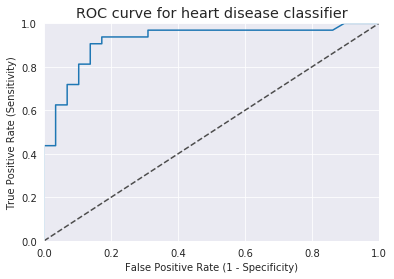

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for heart disease classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

A common metric is the Area Under the Curve, or AUC. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail

Let's see what the above ROC gives us,

In [13]:
auc(fpr, tpr)

0.921875